# Data Wrangling Notebook

In [1]:
import pandas as pd
import os
import requests
import json
import tweepy
from tweepy import OAuthHandler
from timeit import default_timer as timer
from datetime import datetime
import re
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['DejaVu Sans']

In [2]:
os.chdir('projects_on_GitHub/udacity_project/DataWrangling_TwitterData')

## Part I. Gathering Data

### 1. Download Data via URL

In [3]:
# Download `image-predictions.tsv` via url
img_preds_url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"

response = requests.get(img_preds_url)

with open(img_preds_url.split('/')[-1], 'wb') as infile:
    infile.write(response.content)

In [4]:
# Read data from `image-predictions.tsv` as DatFrame
img_pred = pd.read_csv('image-predictions.tsv', sep='\t')

### 2. Read in Data From Local File

In [5]:
twi_archive = pd.read_csv('twitter-archive-enhanced.csv')

### 3. Downloading Data Using `tweepy.API`

In [11]:
consumer_key = 'ZUkqaUXCBVNx80JmAkDhguOww'
consumer_secret = '4mp4ZnNUUqKI1KXYuIgzSNn4m6tTyjXFUnbei1c38NwPeTqPsT'
access_token = '1345946131428085763-T2WTs8ftXzMIoY9bR7vExbjEA1KlNJ'
access_token_secret = '5gfo0DmOTxUVbZVd16eCW6MZb8olQBtglhQ358BBXZ4m8'

In [13]:
# Consumer_key, consumer_secret, access_token, access_secret from twitter developer account
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)


# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
twi_ids = twi_archive.tweet_id.tolist()

In [ ]:
# Save each tweet's returned JSON as a new line in a .txt file
file_name = "tweet_json.txt"
with open(file_name, 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for twi_id in twi_ids:
        count += 1
        print(str(count) + ": " + str(twi_id))
        try:
            tweet = api.get_status(twi_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[twi_id] = e
            pass

end = timer()
print(end - start)
print(fails_dict)

Next, parse the information from each json-formatted records in the text file into a DataFrame.

In [14]:
df_list = []

# Extract the `tweet_id`, `retweet_count` and `favorite_count` from text file
with open('tweet_json.txt', encoding='utf-8', mode='r') as file:
    for tweet in file:
        data = json.loads(tweet)
        tweet_id = data['id']
        retweet_count = data['retweet_count']
        favorite_count = data['favorite_count']
        df_list.append({'tweet_id': int(tweet_id),
                        'retweet_count': int(retweet_count),
                        'favorite_count': int(favorite_count)})

In [15]:
# Convert the list into a DataFrame
twi_count = pd.DataFrame(df_list)
twi_count.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7352,34996
1,892177421306343426,5482,30310
2,891815181378084864,3625,22791
3,891689557279858688,7527,38244
4,891327558926688256,8120,36521


In [16]:
# Check how many failures were made during downloading data using `tweepy.API`
total_ids = len(twi_ids)
failed_ids = len(fails_dict)
failed_pct = failed_ids / total_ids

print("The number of failed ones from extracting information using tweepy.API is {}, \
with its percentage of {:.2%}.".format(failed_ids, failed_pct))

The number of failed ones from extracting information using tweepy.API is 0, with its percentage of 0.00%.


Seen from above, 25 tweet ids failed to extract the information but its percentage compared with the total only covers 1.06%, so it is ok to leave them (failures). 

## Part II. Assessing Data

Now we have three DataFrames, i.e. 
- `twi_archive` -- which is from `twitter-archive-enhanced.csv`.
- `img_pred` -- which is from `image-predictions.tsv`.
- `twi_count` -- which is from `tweet_json.txt`.

**1. Assess the data quality and tidiness in `twi_archive`. The issues will be recorded right above of the `Cleaning Data` part.**

In [17]:
# Randomly select 10 records from the `twi_archive` DataFrame to have a taste of its structure and contents
twi_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
722,783085703974514689,NaN,NaN,2016-10-03 23:25:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Earl. He can't catch. Did his best tho...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/783085703...,11,10,Earl,None,None,None,None
1666,682697186228989953,NaN,NaN,2015-12-31 22:57:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",NAAAAAAA ZAPENYAAAAA MABADI-CHIBAWAAA 12/10 ht...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/682697186...,12,10,None,None,None,None,None
2214,668544745690562560,NaN,NaN,2015-11-22 21:41:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",It is an honor to rate this pup. He is a Snork...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668544745...,10,10,None,None,None,None,None
1977,672988786805112832,NaN,NaN,2015-12-05 04:00:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Schnozz. He's had a blurred tail since...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672988786...,10,10,Schnozz,None,None,pupper,None
1489,692905862751522816,NaN,NaN,2016-01-29 03:03:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Wally. He's being abducted by aliens. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/692905862...,10,10,Wally,None,None,pupper,None
1919,674269164442398721,NaN,NaN,2015-12-08 16:47:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bob. He's a Juniper Fitzsimmons. His b...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674269164...,8,10,Bob,None,None,None,None
1010,747461612269887489,NaN,NaN,2016-06-27 16:08:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Never seen a shark hold another shark like thi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/747461612...,10,10,None,None,None,None,None
215,851224888060895234,NaN,NaN,2017-04-10 00:06:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Snoop. His number one passion is sticking...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/851224888...,13,10,Snoop,None,None,None,None
383,827199976799354881,NaN,NaN,2017-02-02 17:00:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Charlie. He wins every game of chess h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/827199976...,13,10,Charlie,None,None,None,None
238,847116187444137987,NaN,NaN,2017-03-29 16:00:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Unbelievable... We. Only. Rate. Dogs. Please s...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/847116187...,11,10,None,None,None,None,None


In [18]:
# Check each column name and data type within
twi_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [19]:
# Check the tweets which are retweets
twi_archive[~twi_archive.retweeted_status_id.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,746521445350707200,NaN,NaN,2016-06-25 01:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Shaggy. He knows exactl...,6.678667e+17,4.196984e+09,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724...,10,10,Shaggy,None,None,None,None
1043,743835915802583040,NaN,NaN,2016-06-17 16:01:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Extremely intelligent dog here....,6.671383e+17,4.196984e+09,2015-11-19 00:32:12 +0000,https://twitter.com/dog_rates/status/667138269...,10,10,None,None,None,None,None
1242,711998809858043904,NaN,NaN,2016-03-21 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,7.119983e+17,7.832140e+05,2016-03-21 19:29:52 +0000,https://twitter.com/twitter/status/71199827977...,12,10,None,None,None,None,None
2259,667550904950915073,NaN,NaN,2015-11-20 03:51:52 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @dogratingrating: Exceptional talent. Origi...,6.675487e+17,4.296832e+09,2015-11-20 03:43:06 +0000,https://twitter.com/dogratingrating/status/667...,12,10,None,None,None,None,None


In [20]:
# Check the tweets which are replies
twi_archive[~twi_archive.in_reply_to_status_id.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,671550332464455680,6.715449e+17,4.196984e+09,2015-12-01 04:44:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After 22 minutes of careful deliberation this ...,NaN,NaN,NaN,NaN,1,10,None,None,None,None,None
2149,669684865554620416,6.693544e+17,4.196984e+09,2015-11-26 01:11:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",After countless hours of research and hundreds...,NaN,NaN,NaN,NaN,11,10,None,None,None,None,None
2169,669353438988365824,6.678065e+17,4.196984e+09,2015-11-25 03:14:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tessa. She is also very pleased after ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669353438...,10,10,Tessa,None,None,None,None
2189,668967877119254528,6.689207e+17,2.143566e+07,2015-11-24 01:42:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",12/10 good shit Bubka\n@wane15,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None


In [21]:
# Check the statistics summary of each numeric columns
twi_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [22]:
# We found that the smallest number of `rating_numerator` is 0, so check it
twi_archive[twi_archive.rating_denominator==0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None


In [26]:
img_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [27]:
img_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


From above, there are no nulls in it, but the data type for tweet_id should be string instead of integer.

In [28]:
img_pred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [29]:
twi_count.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7352,34996
1,892177421306343426,5482,30310
2,891815181378084864,3625,22791
3,891689557279858688,7527,38244
4,891327558926688256,8120,36521


In [30]:
twi_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2331 non-null   int64
 1   retweet_count   2331 non-null   int64
 2   favorite_count  2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


From above, there are no nulls in it, but the data type for `tweet_id` should be string instead of integer.

### Data Quality Issues

From the codes above (programmatically) and some scrollings in Excel software (visually), I concluded some key data quality and tidiness issues as follows:

**`twi_archive` table**

1. Some rows have values in columns like `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp` which denote that this is a retweet or reply (should be null actually according to the **projejct requirements or Key Points**: "You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.")
2. `tweet_id` is integer not string
3. `timestamp` is object (string) not datetime object; `retweeted_status_timestamp` is the same.
4. `in_reply_to_user_id` and `retweeted_status_id` are float not string
5. `rating_numerator` and `rating_denominator` are integer not float
6. Incorrect dog names in under `name` (e.g. "a" (tweet_id:`881536004380872706`), "my" (tweet_id: `765395769549590528`), "one" (tweet_id: `755206590534418437`, `748575535303884801`), "his" (tweet_id: `748692773788876800`) ...)
7. Incorrect ratings (i.e. **75/10** (actually should be `9.75/10` from tweet_id: `786709082849828864`); rating_denominator is **0** (which is invalid from tweet_id: `835246439529840640`))



**`img_pred` table**

8. `tweet_id` is integer not string



**`twi_count` table**

9. `tweet_id` is integer not string



### Data Tidiness Issues

1. In `twi_archive` table, columns `doggo`, `floofer`, `pupper`, `puppo` distributed in four columns but should be in only one column for one feature instead, namely `dog_stage`.

2. Data are distributed in three tables which should be merged as an integrated one.

## Part III. Cleaning Data

In [32]:
archive_clean = twi_archive.copy()

img_clean = img_pred.copy()

count_clean = twi_count.copy()

**Issue 1: Some rows have values in columns like `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp` which denote that this is a retweet or reply (should be null actually according to the projejct requirements or Key Points: "You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.")**

**Define**

Remove records whose in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp are non-null. Then drop these columns as they are not useful for analysis of this project.

**Code**

In [33]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [34]:
mask1 = archive_clean[~archive_clean.in_reply_to_status_id.isnull()].index
mask2 = archive_clean[~archive_clean.retweeted_status_id.isnull()].index
cols_to_drop = ['in_reply_to_status_id', 'in_reply_to_user_id', \
                'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp']

archive_clean = archive_clean.drop(mask1).reset_index(drop=True)

archive_clean = archive_clean.drop(mask2).reset_index(drop=True)

archive_clean = archive_clean.drop(cols_to_drop, axis=1, )

**Test**

In [35]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   expanded_urls       2093 non-null   object
 5   rating_numerator    2097 non-null   int64 
 6   rating_denominator  2097 non-null   int64 
 7   name                2097 non-null   object
 8   doggo               2097 non-null   object
 9   floofer             2097 non-null   object
 10  pupper              2097 non-null   object
 11  puppo               2097 non-null   object
dtypes: int64(3), object(9)
memory usage: 196.7+ KB


Goal achieved!

**Issue 2: data type in `tweet_id` of `archive_clean` table should be string not integer. The same goes for `img_pred` and `twi_count` table.**

**Define**

Convert data type of `tweet_id` column to be string using `.astype()` function.

**Code**

In [36]:
archive_clean.tweet_id = archive_clean.tweet_id.astype(str)

img_clean.tweet_id = img_clean.tweet_id.astype(str)

count_clean.tweet_id = count_clean.tweet_id.astype(str)

**Test**

In [37]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   object
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   expanded_urls       2093 non-null   object
 5   rating_numerator    2097 non-null   int64 
 6   rating_denominator  2097 non-null   int64 
 7   name                2097 non-null   object
 8   doggo               2097 non-null   object
 9   floofer             2097 non-null   object
 10  pupper              2097 non-null   object
 11  puppo               2097 non-null   object
dtypes: int64(2), object(10)
memory usage: 196.7+ KB


In [38]:
img_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [39]:
count_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2331 non-null   object
 1   retweet_count   2331 non-null   int64 
 2   favorite_count  2331 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 54.8+ KB


**Issue 3: data type in `timestamp` of `archive_clean` table should be datetime object not string.**

**Define**

Convert data type of `timestamp` column to be datetime object using `datetime.strptime()` function.

**Code**

In [40]:
archive_clean.timestamp

0       2017-08-01 16:23:56 +0000
1       2017-08-01 00:17:27 +0000
2       2017-07-31 00:18:03 +0000
3       2017-07-30 15:58:51 +0000
4       2017-07-29 16:00:24 +0000
                  ...            
2092    2015-11-16 00:24:50 +0000
2093    2015-11-16 00:04:52 +0000
2094    2015-11-15 23:21:54 +0000
2095    2015-11-15 23:05:30 +0000
2096    2015-11-15 22:32:08 +0000
Name: timestamp, Length: 2097, dtype: object

In [41]:
# Truncate the ' +0000' in each string records
archive_clean.timestamp = archive_clean.timestamp.str[: -len(' +0000')]

In [42]:
# Check the first 5 records after '+0000' being truncated
archive_clean.timestamp[:5]

0    2017-08-01 16:23:56
1    2017-08-01 00:17:27
2    2017-07-31 00:18:03
3    2017-07-30 15:58:51
4    2017-07-29 16:00:24
Name: timestamp, dtype: object

In [43]:
# Convert the data type in `timestamp` column to datetime object
archive_clean.timestamp = pd.to_datetime(archive_clean['timestamp'], format="%Y-%m-%d %H:%M:%S")

In [44]:
archive_clean.timestamp

0      2017-08-01 16:23:56
1      2017-08-01 00:17:27
2      2017-07-31 00:18:03
3      2017-07-30 15:58:51
4      2017-07-29 16:00:24
               ...        
2092   2015-11-16 00:24:50
2093   2015-11-16 00:04:52
2094   2015-11-15 23:21:54
2095   2015-11-15 23:05:30
2096   2015-11-15 22:32:08
Name: timestamp, Length: 2097, dtype: datetime64[ns]

**Test**

In [45]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2097 non-null   object        
 1   timestamp           2097 non-null   datetime64[ns]
 2   source              2097 non-null   object        
 3   text                2097 non-null   object        
 4   expanded_urls       2093 non-null   object        
 5   rating_numerator    2097 non-null   int64         
 6   rating_denominator  2097 non-null   int64         
 7   name                2097 non-null   object        
 8   doggo               2097 non-null   object        
 9   floofer             2097 non-null   object        
 10  pupper              2097 non-null   object        
 11  puppo               2097 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 196.7+ KB


**Issue 4: Ratings Related Problems**

1. `rating_numerator` and `rating_denominator` are integer not float
2. Incorrect ratings (i.e. **75/10** (actually should be `9.75/10` from tweet_id: `786709082849828864`); rating_denominator is **0** (which is invalid from tweet_id: `835246439529840640`))

**Define**

Use regular expression to re-extract the ratings from text. For the rating_denominator being equal to **0**, it is a retweet and has been removed from above, so it won't be a problem now.

**Code**

In [46]:
# Extract the ratings from text and reassign them into `rating_numerator` and `rating_denominator` column respectively
ratings = archive_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)
archive_clean['rating_numerator'], archive_clean['rating_denominator'] = ratings.loc[:, 0], ratings.loc[:, 1]

# Assign the data type in `rating_numerator` and `rating_denominator` column as float
archive_clean['rating_numerator'] = archive_clean['rating_numerator'].astype('float')
archive_clean['rating_denominator'] = archive_clean['rating_denominator'].astype('float')

In [47]:
# Create a new columns to store the result of rating_numerator/rating_denominator
archive_clean['ratings'] = archive_clean['rating_numerator'] / archive_clean['rating_denominator']

**Test**

In [48]:
# Check the data type of `rating_numerator` and `rating_denominator` columns
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2097 non-null   object        
 1   timestamp           2097 non-null   datetime64[ns]
 2   source              2097 non-null   object        
 3   text                2097 non-null   object        
 4   expanded_urls       2093 non-null   object        
 5   rating_numerator    2097 non-null   float64       
 6   rating_denominator  2097 non-null   float64       
 7   name                2097 non-null   object        
 8   doggo               2097 non-null   object        
 9   floofer             2097 non-null   object        
 10  pupper              2097 non-null   object        
 11  puppo               2097 non-null   object        
 12  ratings             2097 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(9)
memo

In [49]:
# Check the value counts in `ratings` column
archive_clean.ratings.value_counts()

1.200000      476
1.000000      439
1.100000      422
1.300000      287
0.900000      153
0.800000      101
0.700000       51
1.400000       41
0.500000       35
0.600000       32
0.300000       19
0.400000       15
0.200000       10
0.100000        4
0.975000        2
177.600000      1
1.500000        1
0.000000        1
42.000000       1
1.127000        1
1.126000        1
0.636364        1
1.350000        1
3.428571        1
0.818182        1
Name: ratings, dtype: int64

In [89]:
# Check the value counts in `rating_numerator` column
archive_clean.rating_numerator.value_counts()

12.00      472
10.00      437
11.00      417
13.00      287
9.00       153
8.00       101
7.00        52
14.00       41
5.00        34
6.00        32
3.00        19
4.00        16
2.00         9
1.00         5
9.75         2
121.00       1
165.00       1
45.00        1
13.50        1
204.00       1
99.00        1
15.00        1
0.00         1
84.00        1
24.00        1
44.00        1
11.27        1
11.26        1
88.00        1
144.00       1
1776.00      1
50.00        1
80.00        1
60.00        1
420.00       1
Name: rating_numerator, dtype: int64

In [52]:
# Check the value counts in `rating_denominator` column
archive_clean.rating_denominator.value_counts()

10.0     2080
50.0        3
80.0        2
11.0        2
150.0       1
110.0       1
90.0        1
70.0        1
170.0       1
2.0         1
120.0       1
40.0        1
20.0        1
7.0         1
Name: rating_denominator, dtype: int64

**Issue 5: In `twi_archive` table, columns `doggo`, `floofer`, `pupper`, `puppo` distributed in four columns but should be in only one column for one feature instead, namely `dog_stage`.**

**Define**
1. Replace all the values being 'None' with `np.nan`.

2. Create a new column named `dog_stage`. Combine values in `doggo`, `floofer`, `pupper`, `puppo` column under the `dog_stage` column.

**Code**

In [53]:
# Currently under doggo, floofer, pupper, puppo columns, the value 'None' are only string type, 
# first convert them into empty string type

def replace_none(to_replace, rplc, col_names):
    for col_name in col_names:
        archive_clean.loc[archive_clean[col_name]== to_replace, col_name] = rplc

replace_none('None', '', ['doggo', 'floofer', 'pupper', 'puppo'])


In [54]:
# Combine the `doggo`, `floofer`, `pupper`, `puppo` columns as `dog_stage`
archive_clean['dog_stage'] = archive_clean.doggo + archive_clean.floofer + archive_clean.pupper + archive_clean.puppo

# Then gather multiple dog stages.
archive_clean.loc[archive_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
archive_clean.loc[archive_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'
archive_clean.loc[archive_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'

In [55]:
# Replace all empty string under `dog_stage` to np.nan
replace_none('', np.nan, ['dog_stage'])

# Drop columns: doggo, floofer, pupper, puppo
archive_clean.drop(['doggo', 'floofer', 'puppo', 'pupper'], axis=1, inplace=True)

**Test**

In [56]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2097 non-null   object        
 1   timestamp           2097 non-null   datetime64[ns]
 2   source              2097 non-null   object        
 3   text                2097 non-null   object        
 4   expanded_urls       2093 non-null   object        
 5   rating_numerator    2097 non-null   float64       
 6   rating_denominator  2097 non-null   float64       
 7   name                2097 non-null   object        
 8   ratings             2097 non-null   float64       
 9   dog_stage           340 non-null    object        
dtypes: datetime64[ns](1), float64(3), object(6)
memory usage: 164.0+ KB


In [57]:
archive_clean.dog_stage.value_counts()

pupper            229
doggo              67
puppo              24
doggo, pupper      10
floofer             9
doggo, floofer      1
Name: dog_stage, dtype: int64

**Issue 6: Incorrect dog names in under name (Such as "a" in `tweet_id:881536004380872706`, "my" in `tweet_id: 765395769549590528`, "one" in `tweet_id: 755206590534418437, 748575535303884801`, "his" in `tweet_id: 748692773788876800` ...)**

**Define**
1. Find the pattern (**regular expressions**) to retrieve the dog names as many as possible.
2. Set the 'None' (missing or invalid name) to np.nan

**Code**

After checking the `name` column, we found that the invalid names (most of the time) have something in common - which is they are lower case letters or start with lower case letter. (**See as below.**)

In [58]:
archive_clean[archive_clean.name.str.islower()].name.value_counts()

a               53
the              8
an               6
just             4
very             4
one              4
quite            3
not              2
getting          2
mad              2
actually         2
all              1
light            1
my               1
infuriating      1
space            1
old              1
such             1
life             1
this             1
unacceptable     1
by               1
his              1
officially       1
incredibly       1
Name: name, dtype: int64

Moreover, scrolling through the `name` column, we can find some patterns for extracting a valid dog name:

**Patterns for retrieving dog names:**

1. `... named [dog_name]`

2. `Here we have [dog_name]`

3. `This is [dog_name]`

4. `Say hello to [dog_name]`

5. `Meet [dog_name]`

We can use regular expressions on each of these accordingly ...

In [59]:
# Create a complementary column to split the texts in `text` column
archive_clean['text_split'] = archive_clean['text'].str.split()

# Instantiate a list to store the names retrieved by regular expressions
names = []

# Use string starts with method to clean this up
def extract_names(row):
    
    # pattern like 'named Phineas'           
    if 'named' in row['text'] and re.match(r'[A-Z].*', row['text_split'][(row['text_split'].index('named') + 1)]): 
            names.append(row['text_split'][(row['text_split'].index('named') + 1)])
    
    # pattern like 'Here we have Phineas'
    elif row['text'].startswith('Here we have ') and re.match(r'[A-Z].*', row['text_split'][3]):
            names.append(row['text_split'][3].strip('.').strip(','))
            
    # pattern like 'This is Phineas'
    elif row['text'].startswith('This is ') and re.match(r'[A-Z].*', row['text_split'][2]):
            names.append(row['text_split'][2].strip('.').strip(','))
    
    # pattern like 'Say hello to Phineas'
    elif row['text'].startswith('Say hello to ') and re.match(r'[A-Z].*', row['text_split'][3]):
            names.append(row['text_split'][3].strip('.').strip(','))
    
    # pattern like 'Meet Phineas'
    elif row['text'].startswith('Meet ') and re.match(r'[A-Z].*', row['text_split'][1]):
            names.append(row['text_split'][1].strip('.').strip(','))
            
    # If it doesn't match any pattern listed above, then assign the value to string 'None'
    else:
        names.append('None')
        
        
archive_clean.apply(extract_names, axis=1)
archive_clean['names'] = names


**Test**

In [60]:
# Check whether there are still name starting with lower case letter
archive_clean[archive_clean.names.str.islower()]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,ratings,dog_stage,text_split,names


In [61]:
# Check the count number for each name
archive_clean['names'].value_counts()

None            804
Lucy             11
Oliver            9
Charlie           9
Cooper            9
               ... 
Florence          1
Leonidas          1
Shakespeare       1
Crumpet           1
Cleopatricia      1
Name: names, Length: 901, dtype: int64

We can see non-name words like "a", "the" etc. have all been removed.

In [62]:
# Filter the orginal `name` column with 'None' value and newly extracted name column `names` not equal to 'missing'
# Those are names we retrieve using regular expressions
archive_clean[(archive_clean.name=='None') & (archive_clean.names!='None')]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,ratings,dog_stage,text_split,names
419,808106460588765185,2016-12-12 00:29:28,"<a href=""http://twitter.com/download/iphone"" r...",Here we have Burke (pupper) and Dexter (doggo)...,https://twitter.com/dog_rates/status/808106460...,12.0,10.0,None,1.2,"doggo, pupper","[Here, we, have, Burke, (pupper), and, Dexter,...",Burke
1912,669363888236994561,2015-11-25 03:56:01,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Gingivitis Pumpernickel named Z...,https://twitter.com/dog_rates/status/669363888...,10.0,10.0,None,1.0,NaN,"[Here, we, have, a, Gingivitis, Pumpernickel, ...",Zeus.
1922,669037058363662336,2015-11-24 06:17:19,"<a href=""http://twitter.com/download/iphone"" r...",Here we have Pancho and Peaches. Pancho is a C...,https://twitter.com/dog_rates/status/669037058...,10.0,10.0,None,1.0,NaN,"[Here, we, have, Pancho, and, Peaches., Pancho...",Pancho
1971,668268907921326080,2015-11-22 03:24:58,"<a href=""http://twitter.com/download/iphone"" r...",Here we have an Azerbaijani Buttermilk named G...,https://twitter.com/dog_rates/status/668268907...,10.0,10.0,None,1.0,NaN,"[Here, we, have, an, Azerbaijani, Buttermilk, ...",Guss.
2013,667509364010450944,2015-11-20 01:06:48,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",This a Norwegian Pewterschmidt named Tickles. ...,https://twitter.com/dog_rates/status/667509364...,12.0,10.0,None,1.2,NaN,"[This, a, Norwegian, Pewterschmidt, named, Tic...",Tickles.


Now we can drop the original `name` column and use our new retrieved one.

In [63]:
# Drop the complementary column `text_split` and original `name` column
archive_clean.drop(['text_split', 'name'], axis=1, inplace=True)

# Set all the string 'None' in 'names' column to np.nan
archive_clean.loc[archive_clean['names'] == 'None', 'names'] = np.nan

In [64]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2097 non-null   object        
 1   timestamp           2097 non-null   datetime64[ns]
 2   source              2097 non-null   object        
 3   text                2097 non-null   object        
 4   expanded_urls       2093 non-null   object        
 5   rating_numerator    2097 non-null   float64       
 6   rating_denominator  2097 non-null   float64       
 7   ratings             2097 non-null   float64       
 8   dog_stage           340 non-null    object        
 9   names               1293 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(6)
memory usage: 164.0+ KB


**Issue 7: Data are distributed in three tables which should be merged as an integrated one.**

**Define**

Merge three tables using `pd.merge()` function.

**Code**

In [65]:
img_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [66]:
img_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


In [67]:
count_clean.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7352,34996
1,892177421306343426,5482,30310
2,891815181378084864,3625,22791
3,891689557279858688,7527,38244
4,891327558926688256,8120,36521


In [68]:
count_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2331 non-null   object
 1   retweet_count   2331 non-null   int64 
 2   favorite_count  2331 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 54.8+ KB


In [69]:
# Merge the `count_clean` and `img_clean` tables as `count_img_clean`
count_img_clean = pd.merge(count_clean, img_clean, on='tweet_id')
count_img_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        2059 non-null   object 
 1   retweet_count   2059 non-null   int64  
 2   favorite_count  2059 non-null   int64  
 3   jpg_url         2059 non-null   object 
 4   img_num         2059 non-null   int64  
 5   p1              2059 non-null   object 
 6   p1_conf         2059 non-null   float64
 7   p1_dog          2059 non-null   bool   
 8   p2              2059 non-null   object 
 9   p2_conf         2059 non-null   float64
 10  p2_dog          2059 non-null   bool   
 11  p3              2059 non-null   object 
 12  p3_conf         2059 non-null   float64
 13  p3_dog          2059 non-null   bool   
dtypes: bool(3), float64(3), int64(3), object(5)
memory usage: 199.1+ KB


In [70]:
# Merge `count_img_clean` and `archive_clean` as `master_clean`
master_clean = pd.merge(archive_clean, count_img_clean, on='tweet_id', how='left')

In [71]:
# View the merged DataFrame
master_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,ratings,dog_stage,names,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1218,696877980375769088,2016-02-09 02:07:12,"<a href=""http://twitter.com/download/iphone"" r...",This is Misty. She's in a predicament. Not sur...,https://twitter.com/dog_rates/status/696877980...,9.0,10.0,0.9,pupper,Misty,...,1.0,space_heater,0.206876,False,spatula,0.123450,False,vacuum,0.119218,False
850,740995100998766593,2016-06-09 19:52:53,"<a href=""http://twitter.com/download/iphone"" r...",This is Leo. He's a vape god. Blows o's for da...,https://twitter.com/dog_rates/status/740995100...,10.0,10.0,1.0,NaN,Leo,...,1.0,malamute,0.454363,True,Samoyed,0.215967,True,Siberian_husky,0.077500,True
747,751950017322246144,2016-07-10 01:23:49,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Lola. She's a surfing pupper. 13/10 ma...,https://vine.co/v/5WrjaYAMvMO,13.0,10.0,1.3,pupper,Lola,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
451,801285448605831168,2016-11-23 04:45:12,"<a href=""http://twitter.com/download/iphone"" r...",oh h*ck 10/10 https://t.co/bC69RrW559,https://twitter.com/dog_rates/status/801285448...,10.0,10.0,1.0,NaN,NaN,...,1.0,minivan,0.789376,False,beach_wagon,0.081125,False,convertible,0.064534,False
493,793195938047070209,2016-10-31 21:00:23,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Lily. She's pupset that her costu...,https://twitter.com/dog_rates/status/793195938...,12.0,10.0,1.2,puppo,Lily,...,2.0,Labrador_retriever,0.654762,True,golden_retriever,0.074100,True,Chihuahua,0.042339,True


In [72]:
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2097 non-null   object        
 1   timestamp           2097 non-null   datetime64[ns]
 2   source              2097 non-null   object        
 3   text                2097 non-null   object        
 4   expanded_urls       2093 non-null   object        
 5   rating_numerator    2097 non-null   float64       
 6   rating_denominator  2097 non-null   float64       
 7   ratings             2097 non-null   float64       
 8   dog_stage           340 non-null    object        
 9   names               1293 non-null   object        
 10  retweet_count       1883 non-null   float64       
 11  favorite_count      1883 non-null   float64       
 12  jpg_url             1883 non-null   object        
 13  img_num             1883 non-null   float64     

As seen from the master_clean, data type in column `retweet_count`, `favorite_count` and `img_num` should be integer instead of float.

In [73]:
master_clean.dropna(subset=['retweet_count', 'favorite_count'], inplace=True)

master_clean['retweet_count'] = master_clean['retweet_count'].astype(int)
master_clean['favorite_count'] = master_clean['favorite_count'].astype(int)
master_clean['img_num'] = master_clean['img_num'].astype(int)

In [74]:
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1883 entries, 0 to 2096
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1883 non-null   object        
 1   timestamp           1883 non-null   datetime64[ns]
 2   source              1883 non-null   object        
 3   text                1883 non-null   object        
 4   expanded_urls       1883 non-null   object        
 5   rating_numerator    1883 non-null   float64       
 6   rating_denominator  1883 non-null   float64       
 7   ratings             1883 non-null   float64       
 8   dog_stage           289 non-null    object        
 9   names               1249 non-null   object        
 10  retweet_count       1883 non-null   int64         
 11  favorite_count      1883 non-null   int64         
 12  jpg_url             1883 non-null   object        
 13  img_num             1883 non-null   int64       

## Part IV. Storing Master Data


In [75]:
master_clean.to_csv('twitter_archive_master.csv', index=False)

## Part V. Analyzing and Visualizing Data

___FIVE INSIGHTS___:  
    
**1. What are the TOP 10 Tweets favored by most users? And how about the retweets?**

**2. What are the most common dog names?**

**3. What are the most common dog_stage in these tweets?**

**4. What is the ratings distributed like?**

**5. What are the most common breeds found by the neural network?**

---

**1. What are the TOP 3 Tweets favored by most users? And how about the retweets?**

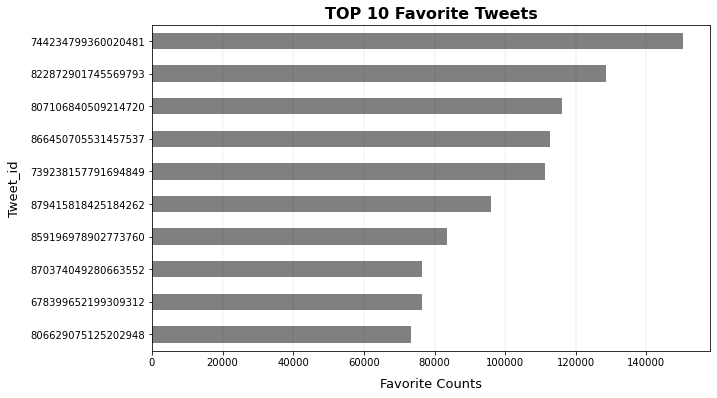

In [76]:
# Top 10 favorite tweets by `favorite_count`
top10_fav = master_clean.sort_values('favorite_count', ascending=False)[['tweet_id','favorite_count']][:10]
top10_fav.reset_index(inplace=True, drop=True)

top10_fav.sort_values('favorite_count').plot(x='tweet_id', \
                                             y='favorite_count', \
                                             width=0.5, \
                                             kind='barh', \
                                             legend=False, \
                                             figsize=(10,6), \
                                             color='grey')

plt.title('TOP 10 Favorite Tweets', fontsize=16, fontweight='semibold')
plt.ylabel('Tweet_id', fontsize=13, labelpad=10)
plt.xlabel('Favorite Counts', fontsize=13, labelpad=10)
plt.grid(axis='x', color='k', linewidth=0.3, linestyle='-.', alpha=0.3);


In [77]:
top10_fav

,tweet_id,favorite_count
0,744234799360020481,150454
1,822872901745569793,128611
2,807106840509214720,116170
3,866450705531457537,112689
4,739238157791694849,111252
5,879415818425184262,96081
6,859196978902773760,83514
7,870374049280663552,76444
8,678399652199309312,76341
9,806629075125202948,73393


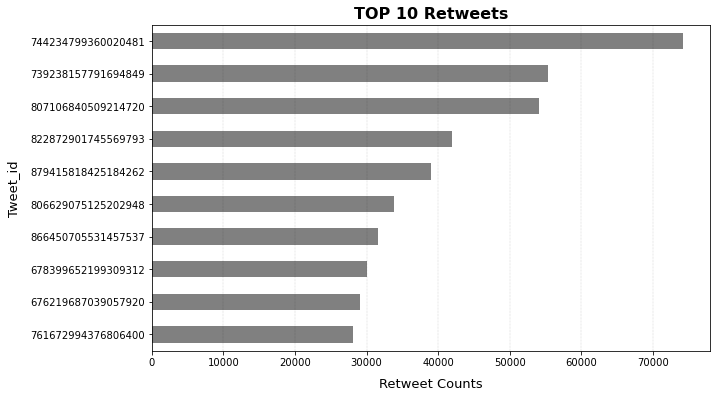

In [78]:
# Top 10 favorite retweets by `retweet_count`
top10_ret = master_clean.sort_values('retweet_count', ascending=False)[['tweet_id','retweet_count']][:10]
top10_ret.reset_index(inplace=True, drop=True)

top10_ret.sort_values('retweet_count').plot(x='tweet_id', \
                                            y='retweet_count', \
                                            width=0.5, \
                                            kind='barh', \
                                            legend=False, \
                                            figsize=(10,6), \
                                            color='grey')

plt.title('TOP 10 Retweets', fontsize=16, fontweight='semibold')
plt.ylabel('Tweet_id', fontsize=13, labelpad=10)
plt.xlabel('Retweet Counts', fontsize=13, labelpad=10)
plt.grid(axis='x', color='k', linewidth=0.3, linestyle='-.', alpha=0.3);

In [79]:
top10_ret

,tweet_id,retweet_count
0,744234799360020481,74276
1,739238157791694849,55350
2,807106840509214720,54159
3,822872901745569793,41872
4,879415818425184262,39014
5,806629075125202948,33886
6,866450705531457537,31608
7,678399652199309312,30035
8,676219687039057920,29071
9,761672994376806400,28063


**2. What are the most common dog names?**

In [80]:
master_clean.names.value_counts()

Lucy            9
Cooper          9
Oliver          9
Penny           8
Winston         8
               ..
Shakespeare     1
Crumpet         1
Naphaniel       1
Zara            1
Cleopatricia    1
Name: names, Length: 880, dtype: int64

**3. What are the most common dog_stage in these tweets?**

In [81]:
master_clean.dog_stage.value_counts()

pupper            198
doggo              53
puppo              20
doggo, pupper      10
floofer             7
doggo, floofer      1
Name: dog_stage, dtype: int64

In [82]:
master_clean.dog_stage.value_counts(normalize=True)

pupper            0.685121
doggo             0.183391
puppo             0.069204
doggo, pupper     0.034602
floofer           0.024221
doggo, floofer    0.003460
Name: dog_stage, dtype: float64

**4. What is the ratings distributed like?**

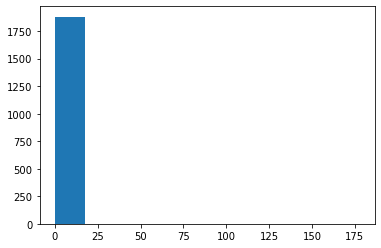

In [83]:
plt.hist(master_clean.ratings);

In [84]:
master_clean.ratings.value_counts()

1.000000      413
1.200000      408
1.100000      384
1.300000      230
0.900000      149
0.800000       94
0.700000       51
0.500000       34
0.600000       32
1.400000       30
0.300000       19
0.400000       15
0.200000       10
0.100000        3
1.127000        1
1.350000        1
3.428571        1
0.636364        1
0.818182        1
1.126000        1
0.975000        1
42.000000       1
177.600000      1
0.000000        1
1.500000        1
Name: ratings, dtype: int64

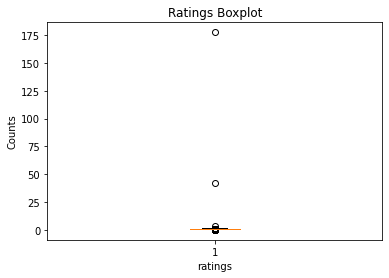

In [85]:
plt.boxplot(master_clean.ratings)

plt.title('Ratings Boxplot')
plt.ylabel('Counts')
plt.xlabel('ratings');

We can see from above, there are two outliers extremely affecting the distribution of the while ratings. We can filter out these two values and check their distribution of the most common rating values.

In [86]:
master_clean.ratings.value_counts().sort_index(ascending=False)

177.600000      1
42.000000       1
3.428571        1
1.500000        1
1.400000       30
1.350000        1
1.300000      230
1.200000      408
1.127000        1
1.126000        1
1.100000      384
1.000000      413
0.975000        1
0.900000      149
0.818182        1
0.800000       94
0.700000       51
0.636364        1
0.600000       32
0.500000       34
0.400000       15
0.300000       19
0.200000       10
0.100000        3
0.000000        1
Name: ratings, dtype: int64

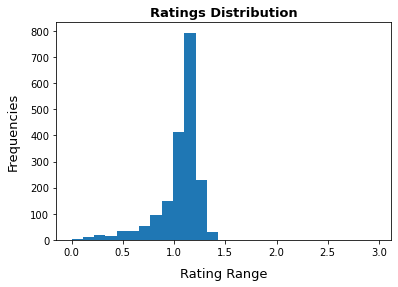

In [87]:
# Filter out the top three outliers
bins = np.arange(master_clean.ratings.min(), 3, 0.11)

# re-plot the histogram
plt.hist(master_clean.ratings, bins=bins)

plt.title('Ratings Distribution', fontsize=13, fontweight='semibold')
plt.ylabel('Frequencies', fontsize=13, labelpad=10)
plt.xlabel('Rating Range', fontsize=13, labelpad=10);

**5. What are the most common breeds found by the neural network?**

In [88]:
master_clean[master_clean['p1_dog']==True].p1.value_counts()

golden_retriever      127
Labrador_retriever     88
Pembroke               79
Chihuahua              75
pug                    55
                     ... 
clumber                 1
Scotch_terrier          1
groenendael             1
Japanese_spaniel        1
silky_terrier           1
Name: p1, Length: 111, dtype: int64